#### Instructions:  
1. Libraries allowed: **Python basic libraries, numpy, pandas, scikit-learn (only for data processing), pytorch, and ClearML.**
2. Show all outputs.
3. Submit jupyter notebook and a pdf export of the notebook. Check canvas for detail instructions for the report.
4. Below are the questions/steps that you need to answer. Add as many cells as needed.

In [97]:
!pip install clearml


In [98]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from clearml import Task as task, Logger
import itertools
import random


## Step 1: Data Processing
1. Partition your dataset into training and test if they are not already. You can do it manually by creating separate folders for training and test.
2. Estimate mean and variance from the training data for normalization.
3. Create "transforms" for training and test for normalization and data augmentation.
4. Create custom dataset or instantiate built-in "ImageFolder" with the transforms for both training and test.
5. Partition the training dataset further into training and validation
6. Use dataloder to partition and generate minibatches.
7. Visualize input and output for two sample images.

In [101]:
# Define the path to dataset
# dataset_dir = '/content/drive/MyDrive/project-1-dataset/Wonders of World'
organized_dir = './organized_ds/organized_dataset'

In [102]:
# 1 - Partition your dataset into training and test if they are not already. You can do it manually by creating separate folders for training and test.

def list_dataset_structure(base_dir):
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')

    def list_folders(directory, set_name):
        if not os.path.exists(directory):
            print(f"{set_name} directory not found.")
            return

        print(f"\n{set_name.upper()} SET:")
        categories = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]

        for category in categories:
            category_path = os.path.join(directory, category)
            images = os.listdir(category_path)

            image_count = len([img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg'))])
            print(f"  Folder: {category} - {image_count} images")

    list_folders(train_dir, 'train')
    list_folders(val_dir, 'validation')
    list_folders(test_dir, 'test')

list_dataset_structure(organized_dir)



TRAIN SET:
  Folder: chichen_itza - 166 images
  Folder: pyramids_of_giza - 166 images
  Folder: roman_colosseum - 166 images
  Folder: taj_mahal - 126 images
  Folder: great_wall_of_china - 166 images
  Folder: machu_pichu - 165 images
  Folder: christ_the_reedemer - 165 images

VALIDATION SET:
  Folder: chichen_itza - 21 images
  Folder: pyramids_of_giza - 21 images
  Folder: roman_colosseum - 21 images
  Folder: taj_mahal - 15 images
  Folder: great_wall_of_china - 21 images
  Folder: machu_pichu - 20 images
  Folder: christ_the_reedemer - 21 images

TEST SET:
  Folder: chichen_itza - 21 images
  Folder: pyramids_of_giza - 21 images
  Folder: roman_colosseum - 21 images
  Folder: taj_mahal - 17 images
  Folder: great_wall_of_china - 20 images
  Folder: machu_pichu - 20 images
  Folder: christ_the_reedemer - 20 images


In [103]:
basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root=organized_dir + "/train", transform=basic_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

indices = np.arange(len(train_dataset))
labels = np.array([label for _, label in train_dataset])

def calculate_mean_std(loader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_pixels = 0

    for images, _ in loader:
        batch_size, channels, height, width = images.shape
        mean += images.sum([0, 2, 3])
        std += (images ** 2).sum([0, 2, 3])
        total_pixels += batch_size * height * width

    mean /= total_pixels
    std = (std / total_pixels - mean ** 2) ** 0.5
    return mean, std


In [104]:
%%time
mean, std = calculate_mean_std(train_loader)
print(f"Estimated mean: {mean}")
print(f"Estimated standard deviation: {std}")

Estimated mean: tensor([0.4972, 0.5083, 0.4875])
Estimated standard deviation: tensor([0.2687, 0.2422, 0.2832])
CPU times: user 31.8 s, sys: 3.28 s, total: 35.1 s
Wall time: 20.4 s


In [120]:
# 3 - Create "transforms" for training and test for normalization and data augmentation.

# Define data transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [122]:
# 4 - Create custom dataset or instantiate built-in "ImageFolder" with the transforms for both training and test.
import os
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms

# Assuming train_transforms and test_transforms are predefined.

class CustomImageDataset:
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        self.classes = os.listdir(image_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        for cls in self.classes:
            class_dir = os.path.join(image_dir, cls)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                self.image_paths.append(img_path)
                self.labels.append(self.class_to_idx[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label


# Define paths for datasets
train_dir = organized_dir + '/train'
val_dir = organized_dir + '/val'
test_dir = organized_dir + '/test'

# Instantiate datasets
train_dataset = CustomImageDataset(image_dir=train_dir, transform=train_transforms)
val_dataset = CustomImageDataset(image_dir=val_dir, transform=test_transforms)
test_dataset = CustomImageDataset(image_dir=test_dir, transform=test_transforms)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check dataset sizes
print(f"Custom training set size: {len(train_dataset)}")
print(f"Custom validation set size: {len(val_dataset)}")
print(f"Custom test set size: {len(test_dataset)}")

Custom training set size: 1120
Custom validation set size: 140
Custom test set size: 140


In [124]:
# 5 - Partition the training dataset further into training and validation
print(f"Training set size: {len(train_dataset)} samples")
print(f"Validation set size: {len(val_dataset)} samples")
print(f"Test set size: {len(test_dataset)} samples")

Training set size: 1120 samples
Validation set size: 140 samples
Test set size: 140 samples


In [126]:
# 6 - Use dataloder to partition and generate minibatches.
# Answer: Minibatch generated in question 4

Visualizing some sample images from the training set:


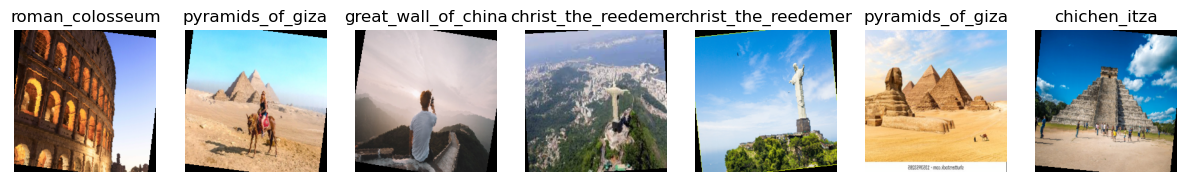

In [128]:
# # 7 - Visualize input and output for two sample images.
def show_sample_images(loader):
    class_names = loader.dataset.classes
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, 7, figsize=(15, 7))
    for i in range(7):
        img = images[i].permute(1, 2, 0).numpy()
        # Assuming mean and std are defined, unnormalize the image

        mean, std = [0.4972, 0.5083, 0.4875],[0.2685, 0.2422, 0.2831]
        img = img * std + mean
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis('off')
    plt.show()

print("Visualizing some sample images from the training set:")
show_sample_images(train_loader)


## Step 2: initial network
1. Create a convolutional neural network. Make the hyper-parameters that you want to tune (e.g., number of layers) dynamic so that you can change them without altering the code. You can choose additional hyperparameters but the followings must be considered.
   1. Number of filters
   2. Number of layers
   3. learning rate
   4. Optimization algorithm specific hyper-paramters, e.g., momentum, for SGD.
   5. weight decay.
3. Select two images. Pick a configuation of NN and hyperparamters and train to overfit the samples, i.e., the accuracy will be 100%. If the network does not overfit, try differnt hyperparamter configuration, e.g., number of paramters, learning rate.

In [132]:
# Step 1: Build CNN class
class CNN(nn.Module):
    def __init__(self, num_layers, num_filters, num_classes, fc_units):
        super(CNN, self).__init__()
        self.convs = nn.ModuleList()
        in_channels = 3

        for _ in range(num_layers):
            self.convs.append(nn.Conv2d(in_channels, num_filters, kernel_size=3, padding=1))
            self.convs.append(nn.ReLU())
            self.convs.append(nn.MaxPool2d(2, 2))
            in_channels = num_filters

        conv_output_size = (224 // (2 ** num_layers))
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_filters * conv_output_size * conv_output_size, fc_units),
            nn.ReLU(),
            nn.Linear(fc_units, num_classes)
        )

    def forward(self, x):
        for layer in self.convs:
            x = layer(x)
        x = self.fc(x)
        return x


In [134]:
# Step 2: Select two images (indices 0 and 1 for simplicity)
subset_indices = [0, 1]
train_subset = Subset(train_dataset, subset_indices)
subset_loader = DataLoader(train_subset, batch_size=2, shuffle=False)


In [136]:
# Step 3: Hyperparameters
hyperparams = {
    "num_layers": 3,
    "num_filters": 64,
    "fc_units": 128,
    "learning_rate": 0.001,
    "momentum": 0.9,
    "weight_decay": 0.0005,
    "epochs": 20
}

In [138]:
# Step 4: Initialize the model, optimizer, and loss function
model = CNN(num_layers=hyperparams["num_layers"],
                   num_filters=hyperparams["num_filters"],
                   num_classes=len(train_dataset.classes),
                   fc_units=hyperparams["fc_units"])

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=hyperparams["learning_rate"],
                      momentum=hyperparams["momentum"],
                      weight_decay=hyperparams["weight_decay"])

In [140]:
# Step 5: Train the model to overfit
def train_overfit(model, loader, optimizer, loss_function, epochs):
    model.train()
    train_losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for images, labels in loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(loader))
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.6f}")

    return train_losses


In [142]:

# Train on the two selected images
train_losses = train_overfit(model, subset_loader, optimizer, loss_function, epochs=hyperparams['epochs'])


Epoch 1/20, Training Loss: 1.935530
Epoch 2/20, Training Loss: 1.899251
Epoch 3/20, Training Loss: 1.842443
Epoch 4/20, Training Loss: 1.771689
Epoch 5/20, Training Loss: 1.686479
Epoch 6/20, Training Loss: 1.588399
Epoch 7/20, Training Loss: 1.463732
Epoch 8/20, Training Loss: 1.293297
Epoch 9/20, Training Loss: 1.061563
Epoch 10/20, Training Loss: 0.834722
Epoch 11/20, Training Loss: 0.604767
Epoch 12/20, Training Loss: 0.295717
Epoch 13/20, Training Loss: 0.134254
Epoch 14/20, Training Loss: 0.050070
Epoch 15/20, Training Loss: 0.014184
Epoch 16/20, Training Loss: 0.005116
Epoch 17/20, Training Loss: 0.001700
Epoch 18/20, Training Loss: 0.000292
Epoch 19/20, Training Loss: 0.000080
Epoch 20/20, Training Loss: 0.000046


In [144]:

# Step 6: Evaluate the model on the two images
def evaluate_overfit(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Overfit Accuracy on the two images: {accuracy:.2f}%")

evaluate_overfit(model, subset_loader)


Overfit Accuracy on the two images: 100.00%


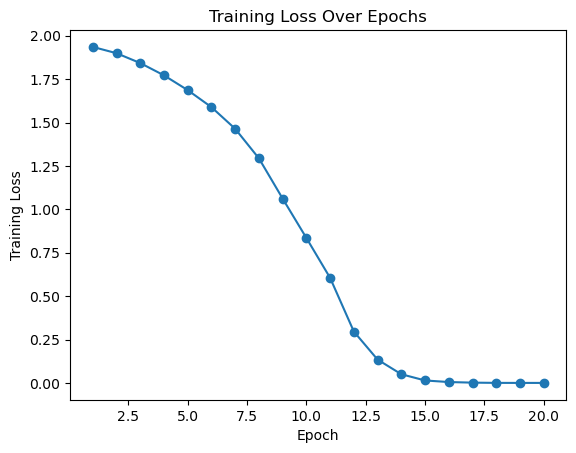

In [146]:
epochs=hyperparams['epochs']
# Step 7: Plot training loss
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Epochs')
plt.show()

## Step 3: ClearML base task
Now train your network with ClearML by creating a task and connecting the parameters to the task. Copy the plots from ClearML and upload them here.

In [149]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ODYR6PYM5NHBOBG1ORU5Q9DY9LTYZH
%env CLEARML_API_SECRET_KEY=JV6KBzwE6Gj7pq7_cZtMUmIwJvkkE8pwlNTDM3RycNXfK_yNOLzjQIQC0h05IHSiHGU

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ODYR6PYM5NHBOBG1ORU5Q9DY9LTYZH
env: CLEARML_API_SECRET_KEY=JV6KBzwE6Gj7pq7_cZtMUmIwJvkkE8pwlNTDM3RycNXfK_yNOLzjQIQC0h05IHSiHGU


In [151]:
import clearml
clearml.browser_login()

In [155]:
# Check if a task is currently active
current_task = task.current_task()
if current_task:
    print(f"Closing the active task: {current_task.name}")
    current_task.close()
else:
    print("No active task.")


No active task.


In [157]:
# Initialize ClearML task

task = task.init(
    project_name="Project 1 - YPY",
    task_name="Project-1-Part-1",
    output_uri=False,
)

ClearML Task: created new task id=939c633e7be3454f9fa122a0462b1210
ClearML results page: https://app.clear.ml/projects/83b2e9bd0ef64b03a8a653e23aec4cba/experiments/939c633e7be3454f9fa122a0462b1210/output/log


In [159]:
params = {
    "num_layers": 3,
    "num_filters": 12,
    "fc_units": 48,
    "learning_rate": 0.001,
    "momentum": 0.9,
    "weight_decay": 0.0005,
    "epochs": 5
}

task.connect(params)

print("ClearML Task initialized and parameters connected!")


ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Task initialized and parameters connected!


In [161]:
model_clearML = CNN(num_layers=params["num_layers"],
                   num_filters=params["num_filters"],
                   num_classes=len(train_dataset.classes),
                   fc_units=params["fc_units"])

loss_function = nn.CrossEntropyLoss()

In [73]:
len(train_dataset.classes)

7

In [163]:
import torch
from sklearn.metrics import accuracy_score
from clearml import Logger

# Assuming `params`, `model_clearML`, `loss_function`, `optimizer`, and `train_loader` are already defined.


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model and loss function to the GPU
model_clearML = model_clearML.to(device)
loss_function = loss_function.to(device)

# Recreate the optimizer with the model's parameters on the correct device
optimizer = optim.SGD(model_clearML.parameters(),
                      lr=params["learning_rate"],
                      momentum=params["momentum"],
                      weight_decay=params["weight_decay"])

for epoch in range(params['epochs']):
    model_clearML.train()  # Set the model to training mode

    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch in train_loader:
        # Unpack the batch (assuming batch contains inputs and targets)
        inputs, targets = batch

        # Move inputs and targets to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model_clearML(inputs)
        loss = loss_function(outputs, targets)

        # Zero gradients, backward pass, and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update total loss
        total_loss += loss.item()

        # Calculate predictions and accuracy
        _, predicted = outputs.max(1)  # Get the predicted class (assuming classification task)
        correct_predictions += (predicted == targets).sum().item()
        total_samples += targets.size(0)

        # # Log training loss to ClearML
        # Logger.current_logger().report_scalar(
        #     title="Loss",
        #     series="Training Loss",
        #     iteration=epoch,
        #     value=loss.item()
        # )

    # Calculate average loss and accuracy for the epoch
    avg_loss = total_loss / len(train_loader)
    Logger.current_logger().report_scalar(
            title="Loss",
            series="Training Loss",
            iteration=epoch,
            value=avg_loss
        )
    accuracy = correct_predictions / total_samples * 100

    # Log accuracy to ClearML
    Logger.current_logger().report_scalar(
        title="Accuracy",
        series="Train Accuracy",
        iteration=epoch,
        value=accuracy
    )

    print(f"Epoch {epoch + 1}/{params['epochs']} - Training Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/5 - Training Loss: 1.9417, Accuracy: 16.96%
Epoch 2/5 - Training Loss: 1.9015, Accuracy: 24.82%
Epoch 3/5 - Training Loss: 1.8039, Accuracy: 29.91%
Epoch 4/5 - Training Loss: 1.7336, Accuracy: 31.87%
Epoch 5/5 - Training Loss: 1.7037, Accuracy: 34.38%


In [165]:
task.close()

# **Loss**

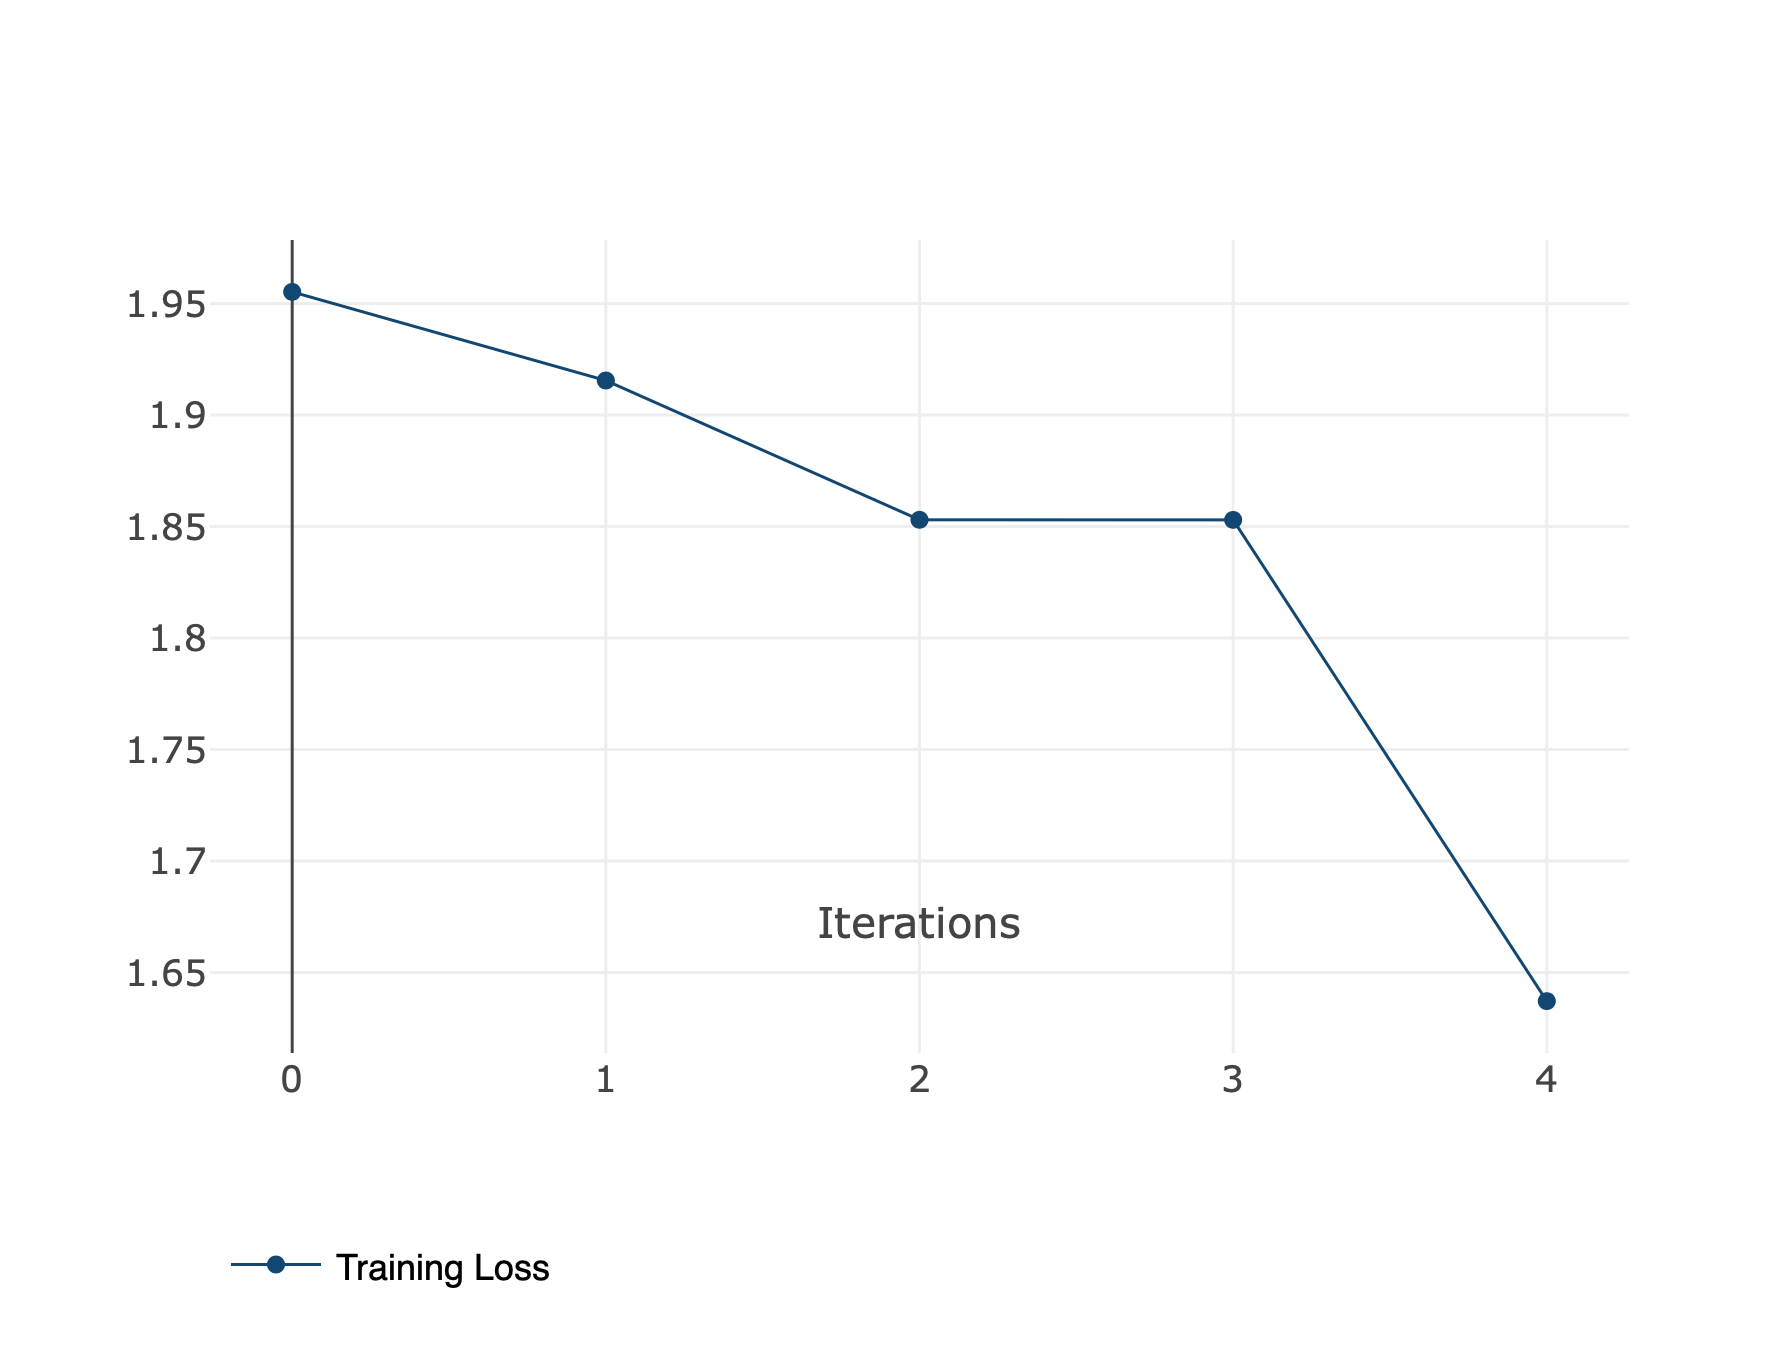

In [180]:
from IPython.display import Image, display
image_path = "Loss-3.png"
display(Image(filename=image_path))

# **Accuracy**

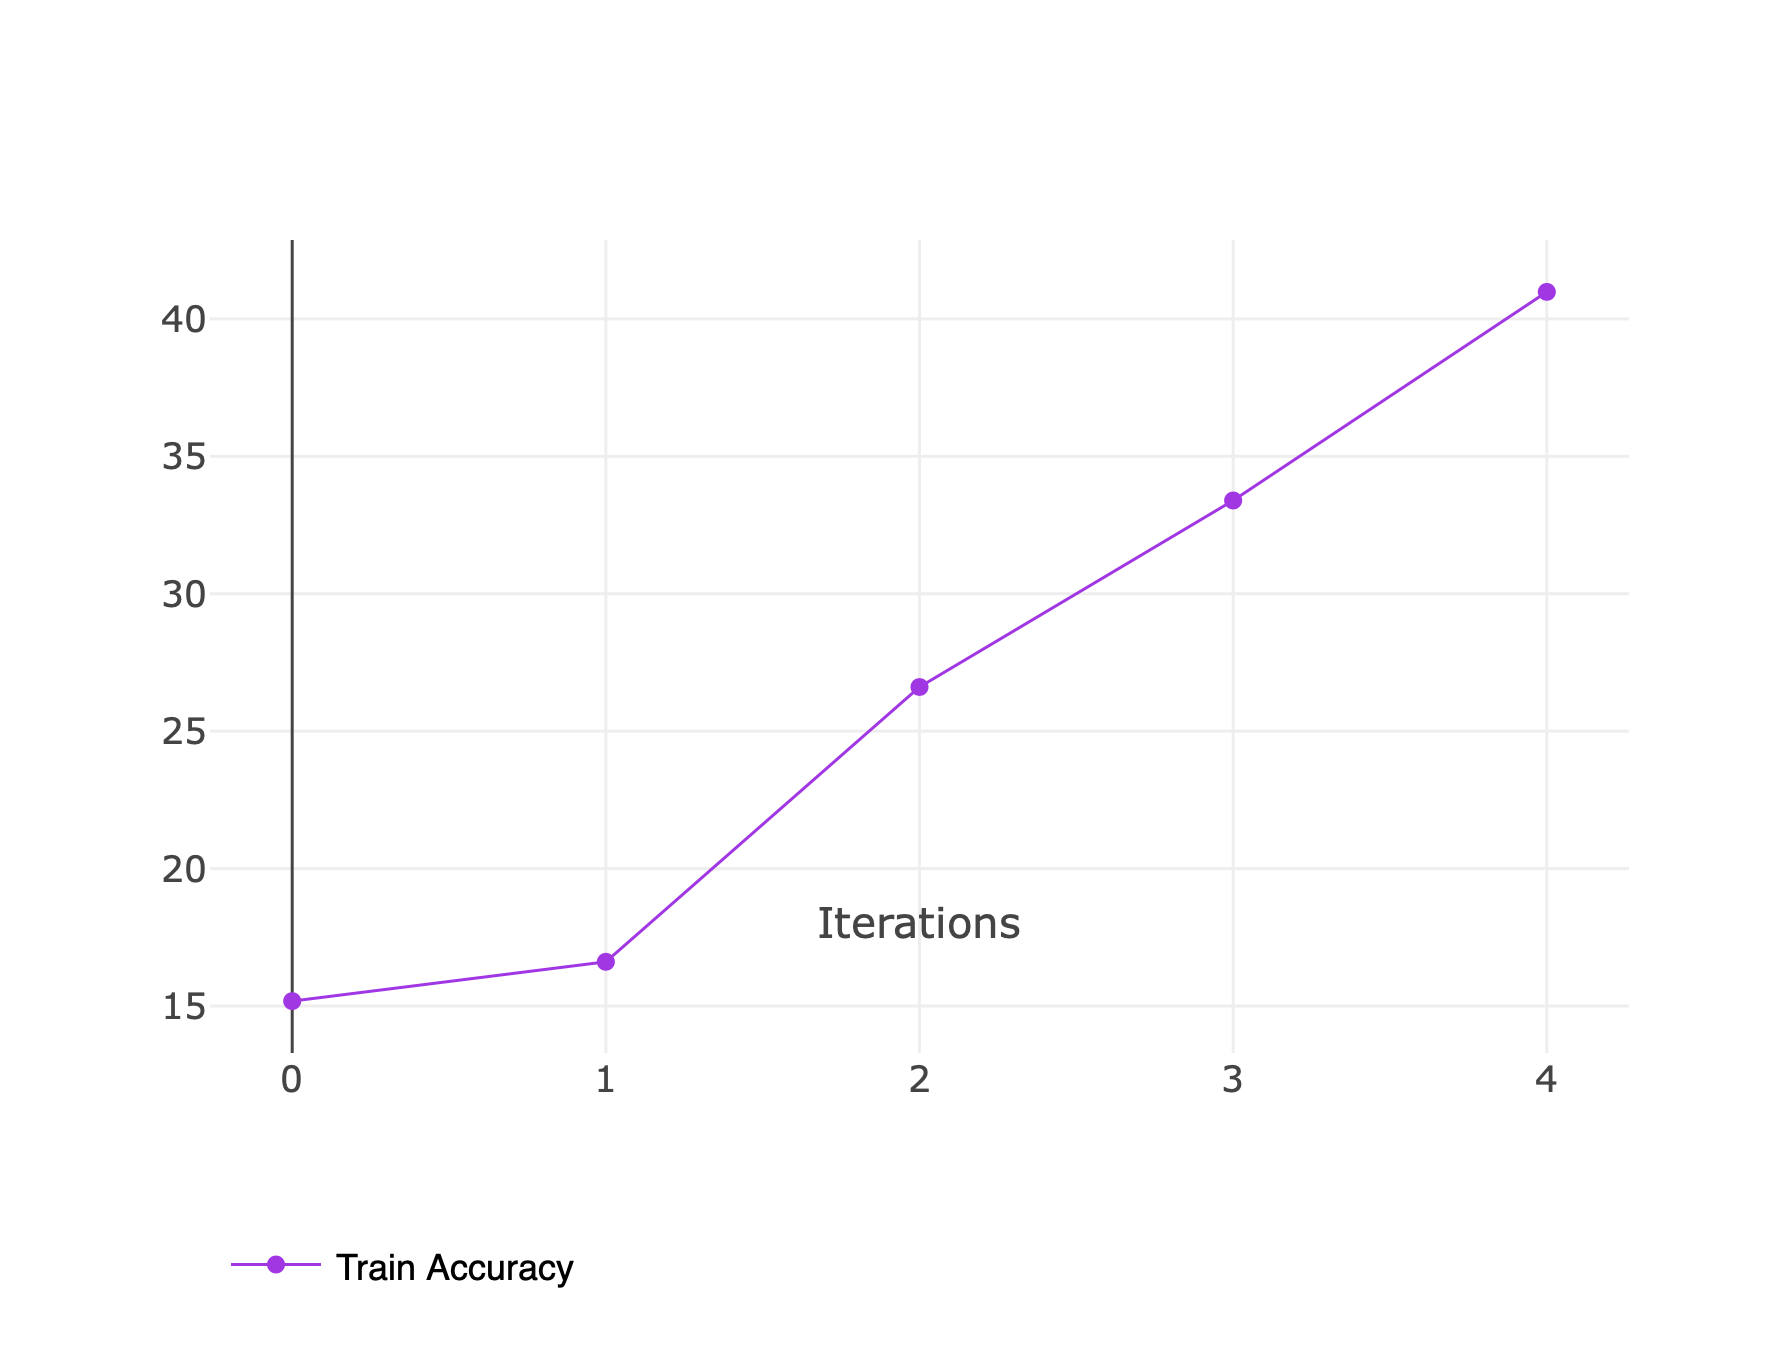

In [182]:
image_path = "./Accuracy-3.png"
display(Image(filename=image_path))